<a href="https://colab.research.google.com/github/fargila/Vision-Transformer/blob/main/Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# Building a vision transformer with CIFAR-10 dataset
```



## Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import random
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from ast import Param
from tqdm.auto import tqdm

## Setup Device-Agnostic Code

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Setting the seed


In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

## Setting the hyperparameters

In [ ]:
BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 3e-4
PATCH_SIZE = 4
NUM_CLASSES = 10
NUM_HEADS = 8
IMAGE_SIZE = 32
CHANNELS = 3
EMBED_DIM = 256
DEPTH = 6
MLP_DIM = 512
DROP_RATE = 0.1

## Define image transformations


In [ ]:
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5), (0.5))
# ])

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

## Getting a dataset

In [ ]:
trains_dataset = datasets.CIFAR10(root="data", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root="data", train=False, download=True, transform=transform)

## Converting the datasets into dataloaders

In [ ]:
train_loader = DataLoader(trains_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Data loader: {train_loader, test_loader}")
print(f"Length of train loader: {len(train_loader)} batches of {BATCH_SIZE}...")
print(f"Length of test loader: {len(test_loader)} batches of {BATCH_SIZE}...")

Data loader: (<torch.utils.data.dataloader.DataLoader object at 0x7b5cbc89b590>, <torch.utils.data.dataloader.DataLoader object at 0x7b5cbcbadb90>)
Length of train loader: 391 batches of 128...
Length of test loader: 79 batches of 128...


## Building the **Vision Transformer**

In [ ]:
class PatchEmbedding(nn.Module):
  def __init__(self, img_size, patch_size, in_channels, embed_dim):
    super().__init__()
    self.patch_size = patch_size
    self.proj = nn.Conv2d(in_channels,  embed_dim,  kernel_size=patch_size, stride=patch_size)
    num_patches = (img_size // patch_size) ** 2
    self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
    self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))

  def forward(self, x: torch.Tensor):
    B = x.size(0)
    x = self.proj(x)
    x = x.flatten(2).transpose(1, 2)
    cls_token = self.cls_token.expand(B, -1, -1)
    x = torch.cat((cls_token, x), dim=1)
    x += self.pos_embed
    return x

In [ ]:
class MLP(nn.Module):
  def __init__(self, in_features, hidden_features, drop_rate):
    super().__init__()
    self.fc1 = nn.Linear(in_features, out_features=hidden_features)
    self.gelu = nn.GELU() # Changed from F.gelu
    self.fc2 = nn.Linear(in_features=hidden_features, out_features=in_features)
    self.drop = nn.Dropout(drop_rate)

  def forward(self, x):
    # Changed F.gelu(self.fc1(x)) to self.gelu(self.fc1(x))
    x = self.drop(self.gelu(self.fc1(x)))
    x = self.drop(self.fc2(x))
    return x

In [ ]:
class TransformerEncoderLayer(nn.Module):
  def __init__(self, embed_dim, mlp_dim, num_heads, drop_rate):
    super().__init__()
    self.norm1 = nn.LayerNorm(embed_dim)
    self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=drop_rate, batch_first=True)
    self.norm2 = nn.LayerNorm(embed_dim)
    self.mlp = MLP(embed_dim, mlp_dim, drop_rate)

  def forward(self, x):
    # Added .clone() after the attention layer output
    x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0].clone()
    x = x + self.mlp(self.norm2(x))
    return x

In [ ]:
class VisionTransformer(nn.Module):
  def __init__(self, img_size, patch_size, in_channels, num_classes,
                      embed_dim, depth, num_heads, mlp_dim, drop_rate):
    super().__init__()
    self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
    self.encoder = nn.Sequential(*[TransformerEncoderLayer(embed_dim,
                                                      mlp_dim, num_heads, drop_rate)
      for _ in range(depth)
    ])
    self.norm = nn.LayerNorm(embed_dim)
    self.fc = nn.Linear(embed_dim, num_classes)

  def forward(self, x):
    x = self.patch_embed(x)
    x = self.encoder(x)
    x = self.norm(x)
    cls_token = x[:, 0]
    return self.fc(cls_token)

In [ ]:
model = VisionTransformer(IMAGE_SIZE, PATCH_SIZE, CHANNELS, NUM_CLASSES, EMBED_DIM,
                                             DEPTH, NUM_HEADS, MLP_DIM, DROP_RATE).to(device)

## Defining a loss function and an optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Defining a Training Loop function

In [ ]:
def train(model, loader, optimizer, criterion):
  model.train()
  total_loss, correct = 0, 0

  for x, y in loader:
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    out = model(x)
    loss = criterion(out, y)
    loss.backward()
    optimizer.step()

    total_loss += loss.item() * x.size(0)
    correct += (out.argmax(1) == y).sum().item()
  return total_loss / len(loader.dataset), correct / len(loader.dataset)

In [ ]:
def evaluate(model, loader):
  model.eval()
  correct = 0
  with torch.inference_mode():
    for x, y in loader:
      x, y = x.to(device), y.to(device)
      out = model(x)
      correct += (out.argmax(dim=1) == y).sum().item()
  return correct / len(loader.dataset)

In [ ]:
from tqdm.auto import tqdm

In [ ]:
train_accuracies, test_accuracies = [], []

for epoch in tqdm(range(EPOCHS)):
  train_loss, train_acc = train(model, train_loader, optimizer, criterion)
  test_acc = evaluate(model, test_loader)
  train_accuracies.append(train_acc)
  test_accuracies.append(test_acc)
  print(f"Epoch: {epoch + 1}/{EPOCHS}, Train Loss: {train_loss:.4f},"
           f"Train Acc: {train_acc:.4f}%, Test Acc: {test_acc:.4f}%")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/10, Train Loss: 1.7331,Train Acc: 0.3708%, Test Acc: 0.4770%
Epoch: 2/10, Train Loss: 1.3834,Train Acc: 0.5039%, Test Acc: 0.5328%
Epoch: 3/10, Train Loss: 1.2328,Train Acc: 0.5584%, Test Acc: 0.5723%
Epoch: 4/10, Train Loss: 1.1271,Train Acc: 0.5967%, Test Acc: 0.5822%
Epoch: 5/10, Train Loss: 1.0379,Train Acc: 0.6279%, Test Acc: 0.6069%
Epoch: 6/10, Train Loss: 0.9662,Train Acc: 0.6542%, Test Acc: 0.6187%
Epoch: 7/10, Train Loss: 0.8885,Train Acc: 0.6824%, Test Acc: 0.6242%
Epoch: 8/10, Train Loss: 0.8157,Train Acc: 0.7079%, Test Acc: 0.6134%
Epoch: 9/10, Train Loss: 0.7457,Train Acc: 0.7352%, Test Acc: 0.6314%
Epoch: 10/10, Train Loss: 0.6707,Train Acc: 0.7621%, Test Acc: 0.6319%


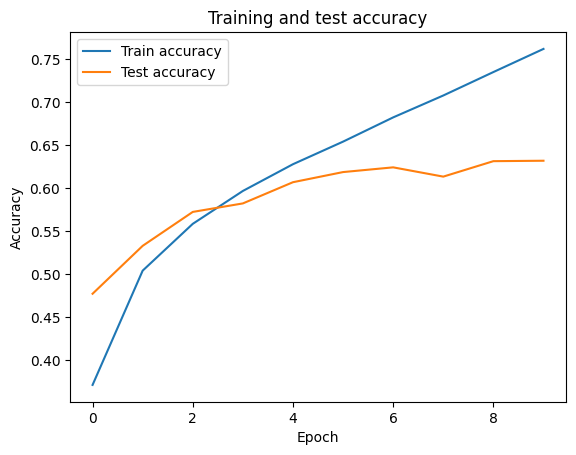

In [ ]:
plt.plot(train_accuracies, label="Train accuracy")
plt.plot(test_accuracies, label="Test accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and test accuracy")
plt.show()

In [ ]:
def predict(model, dataset, classes, grid_size=3):
  model.eval()
  fig, plt.axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

  for i in range(grid_size):
    for j in range(grid_size):
      idx = random.randint(0, len(dataset) - 1)
      img, true_label = dataset[idx]
      input_tensor = img.unsqueeze(dim=0).to(device)
      with torch.inference_mode():
        output = model(input_tensor)
        _, predicted = torch.max(output.data, 1)
      img = img / 2 + 0.5
      npimg = img.cpu().numpy()
      plt.axes[i, j].imshow(np.transpose(npimg, (1, 2, 0)))
      truth = classes[true_label] == classes[predicted.item()]

      if truth: color = "g"
      else: color = "r"
      plt.axes[i, j].set_title(f"Truth: {classes[true_label]}\n, Predicted: {classes[predicted.item()]}",
      fontsize=10, c=color)
      plt.axes[i, j].axis("off")

  plt.tight_layout()
  plt.show()

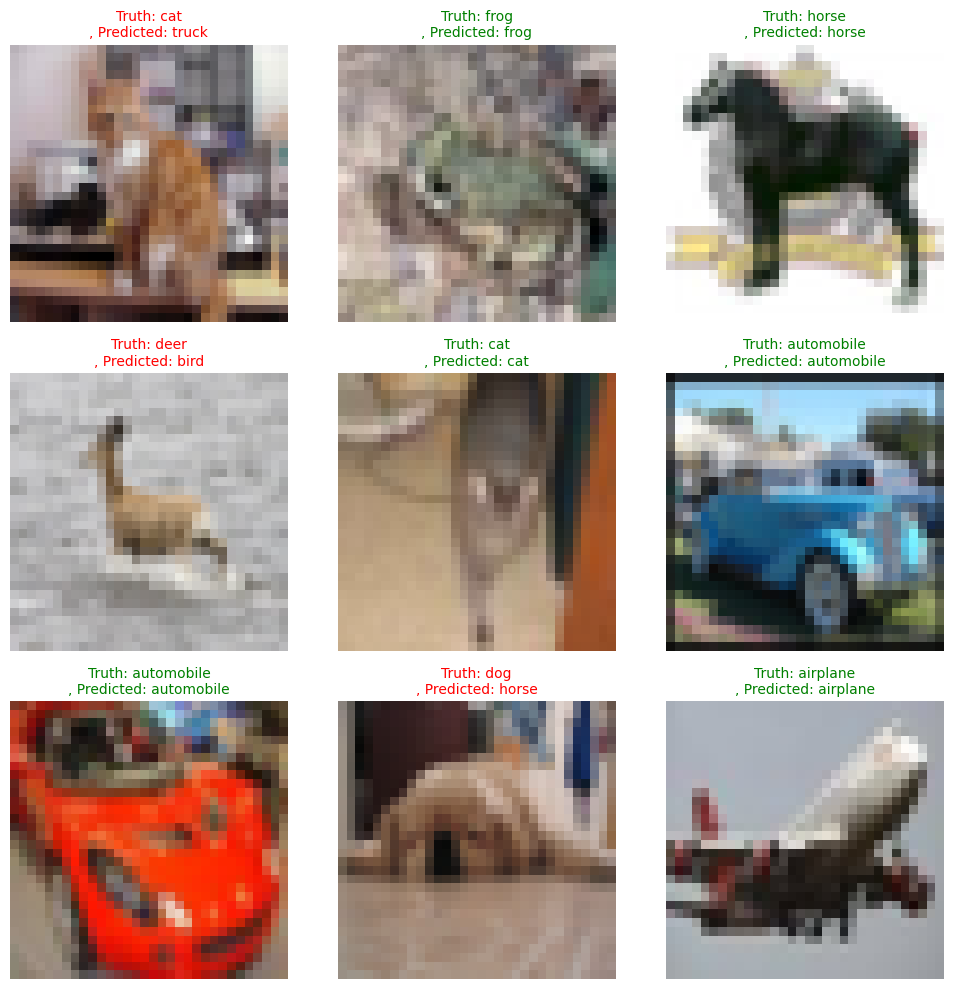

In [ ]:
predict(model, test_dataset, classes=trains_dataset.classes, grid_size=3)

### To get better at this, go to -> **https://docs.pytorch.org/vision/0.9/transforms.html**